In [33]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [34]:
import gc, sys
sys.path.append('..')

from fastai.callback.all import *
from fastai.data.block import CategoryBlock, ColReader, ColSplitter, DataBlock, IndexSplitter, RegressionBlock
from fastai.imports import *
from fastai.learner import *
from fastai.optimizer import Adam
from fastai.metrics import *
from fastai.torch_core import *
from fastai.torch_imports import *
import torch
from transformers import AutoModelForSequenceClassification, logging

from blurr.callbacks import GradientCheckpointing
from blurr.text.data.core import TextBlock
from blurr.text.modeling.core import BaseModelWrapper, BaseModelCallback, blurr_splitter
from blurr.text.utils import get_hf_objects
from blurr.utils import PreCalculatedMSELoss, print_versions, set_seed

from kaggle_comp import utils

from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

from sklearn.metrics import mean_squared_error
from fastai.metrics import rmse, AccumMetric

from fastai.losses import MSELossFlat, L1LossFlat

from torch.nn import MSELoss
from torch import nn

# silence all the HF warnings
warnings.simplefilter("ignore")
logging.set_verbosity_error()
os.environ["TOKENIZERS_PARALLELISM"] = "false"


In [37]:
import transformers
import fastai
import blurr

transformers.__version__, fastai.__version__, blurr.__version__

('4.22.0', '2.7.9', '1.0.5')

## Setup/Configuration

In [3]:
device_num = 0
seed = 42 or utils.default_seed

torch.cuda.set_device(device_num)
print(f"Using GPU #{torch.cuda.current_device()}: {torch.cuda.get_device_name()}")


Using GPU #0: GeForce GTX 1660 Ti with Max-Q Design


In [4]:
raw_data_path = Path("../../data/comp")
clean_data_path = Path("../../data/clean")

## Competition Data

Training set

In [5]:
# this is already the train data with folds:
# train_df = pd.read_csv(clean_data_path / "train_folds.csv")

# the raw training data, for processing from scratch:
train_df = pd.read_csv(raw_data_path / "train.csv")


print(f"# of rows in TRAIN: {len(train_df)}")
train_df.head()

# of rows in TRAIN: 3911


,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,"I think that students would benefit from learning at home,because they wont have to change and get up early in the morning to shower and do there hair. taking only classes helps them because at there house they'll be pay more attention. they will be comfortable at home.\n\nThe hardest part of school is getting ready. you wake up go brush your teeth and go to your closet and look at your cloths. after you think you picked a outfit u go look in the mirror and youll either not like it or you look and see a stain. Then you'll have to change. with the online classes you can wear anything and st...",3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it do the best on you no matter what is happening it can change your mind. sometimes you need to wake up and look what is around you because problems are the best way to change what you want to change along time ago. A\n\nproblem is a change for you because it can make you see different and help you to understand how tings wok.\n\nFirst of all it can make you see different then the others. For example i remember that when i came to the United States i think that nothing was going to change me because i think that nothing was going to change me bec...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal\n\nIf u change the school policy of having a grade b average that unfair. Because many students have a C average. So that means that they cant go out for sports or other activities they want to do bad. That's like taking everything they have. What if kids want to become good at something, but now they cant because of that school policy. If they have a C average they should still be able to go out for sports or activities. A C average isn't that bad, its higher then a D average. If the school police was if you have a D average of lower they shouldn't do sports or activities....",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,"The best time in life is when you become yourself. I agree that the greatest accomplishment, is when you be yourself in a world that constantly trying to make you something else. Because you make your own choices, you become more happy, and you respect others.\n\nFirst, you make your own choices by being yourself. Becoming yourself means that you should be able to make your own choices and not be shy or afraid of what you're doing. Because you're defining yourself by doing those things that you want. Some people follow others, therefore, they don't make their own choices. People are afraid...",4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,Small act of kindness can impact in other people can change people to become better persons you can have an impact of kindess with a homeles that can change his life or with some who needed they are going to know you are a nice person if you are a nice person everywhere you go people is going to like your personality so you have to be a nice person with others like a old women triying to cross the road thats a impact of kindness when you do that you feel a greate person you can change people in the way they think by helping others treating nice other people give them some advice when you s...,2.5,3.0,3.0,3.0,2.5,2.5


Test set

In [6]:
test_df = pd.read_csv(raw_data_path / "test.csv")

print(f"# of rows in TEST: {len(test_df)}")
test_df.head()

# of rows in TEST: 3


,text_id,full_text
0,0000C359D63E,when a person has no experience on a job their is always going to be good people to help you and try to explane the job you need to get done in life you were not born with knowing everything. Life is bassicly about learing new things every single day even though without experience because life is simple and we must live happy and around with the people we love. When a person thinks they know everything in life they dont do good because they trying to make the other person less then others you must be kind to those the dont have experience because you may not know some day you will go to a ...
1,000BAD50D026,"Do you think students would benefit from being able attend classes from home?\n\nYes! its benefit for student who attend classes from home. Because some student want to attend classes from home because they thinks it's very important for them . And they think they can learned fast, and understand than they student who attend classes from school. For example my friend told me that she's attand classes from home it's good for her, because they is some subject she didn't understand when she attend classes from school but when she attend the home classes she good for that subject. she like sci..."
2,00367BB2546B,"Thomas Jefferson once states that ""it is wonderful how much we can get done when we are always doing something,I agree to this statement. Some people say that it is always better to always be doing something than to be inactive and so nothing at all to chase after on your dreams. always doing something lets you feel a sense of accomplishment,it makes you want to strive to do even more than what you did,you can also learn something along the way.\n\nThe first reason that always doing is better than doing nothing is that it gives you a sense of you accomplishing something. when you finish a ..."


## Baseline

### Step 1: Get HF objects

In [7]:
model_checkpoint = "microsoft/deberta-v3-small"
#model_checkpoint = "distilroberta-base"
#batch_size = 128
batch_size = 4
weight_decay = 0.01


In [8]:
hf_arch, hf_config, hf_tokenizer, hf_model = get_hf_objects(
    model_checkpoint, model_cls=AutoModelForSequenceClassification, config_kwargs={"num_labels": 6}
)
hf_model.config.problem_type = "multi_label_regression"


In [9]:
hf_model

DebertaV2ForSequenceClassification(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0): DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
 

### Step 2: Build your `DataLoaders`

#### Step 2a: Define a good validation set

Using 5-fold `MultilabelStratifiedKFold` already here, since we'll use that later anyway, and pick fold 0 as the validation fold. We stratify by the 6 target columns:

In [10]:
target_cols = [x for x in train_df.columns if x not in ['text_id', 'full_text', 'k_fold']]
target_cols

['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']

In [11]:
skf = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=4321)

for fold, (_, val_index) in enumerate(skf.split(X = train_df, y = train_df[target_cols])):
    train_df.loc[val_index, 'fold'] = fold

train_df['fold'] = train_df['fold'].astype(int)

In [12]:
train_df['is_valid'] = train_df['fold'] == 0

In [13]:
train_df.is_valid.value_counts()

False    3129
True      782
Name: is_valid, dtype: int64

#### Step 2b: Define your `DataBlock`

We'll use blurr's `set_seed()` method to ensure reproducibility (which is important as you iterate over different hyperparameters, explore different augmentation strategies, etc...). For a great discussion on how to do this in fastai, see the ["[Solved] Reproducibility: Where is the randomness coming in?"](https://forums.fast.ai/t/solved-reproducibility-where-is-the-randomness-coming-in/31628/25) post on the forums.

In [14]:
set_seed(seed)
sep = f" {hf_tokenizer.sep_token} "

blocks = (TextBlock(hf_arch, hf_config, hf_tokenizer, hf_model, max_length=128), RegressionBlock(n_out = 6))
dblock = DataBlock(
    blocks=blocks,
    get_x=ColReader('full_text'),
    get_y=ColReader(target_cols),
    splitter=ColSplitter(),
)


#### Step 2c: Get your `DataLoaders`

In [15]:
set_seed(seed)
dls = dblock.dataloaders(train_df, bs=batch_size) #.cpu()

In [16]:
dls.show_batch(dataloaders=dls, max_n=2, trunc_at=500)

,text,target
0,"Success consist of going from failure to failure withouth loss of enthusiasm, and I'm agree with this statement, because can do what it wants if try and try, and everything is doing with effort, and than a failure can be for a better oportunity in the future. Did you heard that failured means success sometime? well effort is the best way that you can reach what you wish. Can do what it wants if try and try, so let me tell you something about a friend that is close to me, and he was in failre to","(3.0, 2.5, 3.0, 2.5, 3.0, 2.5)"
1,"Summer vacation is a good break for the students to spend time with their family, also a good way to take a break form school and your annoying classes, to take some rest, change your mind, and think about what will you change, when you go back to school, also taking a long summer vacation will get yourself out of stress. you will be able to do other think than just memorizing stuff you don't need in a real life, that's why it's not a good idea to reduce students summer break just because educat","(3.0, 3.5, 3.0, 3.5, 2.5, 3.0)"


In [17]:
b = dls.one_batch()
len(b), len(b[0]["input_ids"]), b[0]["input_ids"].shape, len(b[1])

(2, 4, torch.Size([4, 128]), 4)

In [18]:
b[0]

{'input_ids': tensor([[     1,  10159,   8200,    265,    446,    292,   2694,    264,   2694,
             497,   1537,   1265,    265,   8143,    261,    263,    273,    280,
             358,   1757,    275,    291,   1548,    261,    401,    295,    333,
             339,    278,   1654,    337,    687,    263,    687,    261,    263,
             758,    269,    653,    275,   1622,    366,    263,    354,    266,
            2694,    295,    282,    270,    266,    493,   2673,   8690,  50451,
             267,    262,    723,    260,   2709,    274,   1331,    272,   2694,
             407,    666,   1228,   8684,    302,    371,   1622,    269,    262,
             410,    384,    272,    274,    295,   1431,    339,    274,   1437,
             260,   1194,    333,    339,    278,   1654,    337,    687,    263,
             687,    261,    324,    678,    351,    848,    274,    491,    314,
             266,   1156,    272,    269,    828,    264,    351,    261,    263,
   

In [19]:
b[1], b[1].shape

(tensor([[3.0000, 2.5000, 3.0000, 2.5000, 3.0000, 2.5000],
         [2.5000, 2.5000, 3.0000, 2.5000, 2.0000, 2.5000],
         [3.5000, 3.5000, 4.0000, 3.0000, 3.0000, 3.0000],
         [2.5000, 2.5000, 3.5000, 2.5000, 2.5000, 2.5000]], device='cuda:0'),
 torch.Size([4, 6]))

### Step 3: Train a model

Sticking with blurr's mid-level API, let's define our `Learner`.  You can learn all about the blurr specific bits [here](https://ohmeow.github.io/blurr/text-modeling-core.html).

Your metric should reflect your objective, and in the case of kaggle comps they tell you exactly what that is.

In [20]:
# | export
def comp_metric_score(preds, targs):
    """This competition is evaluated using "columnwise root mean squared error". Expects numpy arrays."""
    len_target_cols = targs.shape[1]
    score = [0] * len_target_cols
    for i in range(len_target_cols):
        score[i] = np.sqrt(mean_squared_error(preds[:, i], targs[:, i]))
    return np.mean(score)

In [21]:
#| export
def MCRMSE(dim_argmax=None, **kwargs):
    "columnwise root mean squared error for regression problem"
    def mcrmse(x,y): return comp_metric_score(x,y)
    return AccumMetric(mcrmse, invert_arg=False, flatten=False, dim_argmax=dim_argmax, **kwargs)

MCRMSE loss from here:

https://www.kaggle.com/code/masashisode/pytorch-implementation-of-mcrmseloss

In [22]:
class RMSELoss_0(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps

    def forward(self, yhat, y):
        loss = torch.sqrt(self.mse(yhat, y) + self.eps)
        return loss


class MCRMSELoss(nn.Module):
    def __init__(self, num_scored=6):
        super().__init__()
        self.rmse = RMSELoss_0()
        self.num_scored = num_scored

    def forward(self, yhat, y):
        score = 0
        for i in range(self.num_scored):
            score += self.rmse(yhat[:, i], y[:, i]) / self.num_scored

        return score


In [23]:
#from fastai.losses import *

In [24]:
set_seed(seed)

model = BaseModelWrapper(hf_model)
learn_cbs = [BaseModelCallback]
fit_cbs = []

learn = Learner(
    dls,
    model,
    opt_func=partial(Adam, wd=weight_decay),
    loss_func=MCRMSELoss(),
    metrics=[MCRMSE()],
    #loss_func=BCEWithLogitsLossFlat(),  # PreCalculatedBCELoss()
    #metrics=[partial(accuracy_multi, thresh=0.2)],
    #loss_func=MSELoss(),
    #metrics=[rmse],
    cbs=learn_cbs,
    splitter=blurr_splitter,
) #.to_fp16()

#learn = learn.to_fp16()


In [26]:
learn.summary()

BaseModelWrapper (Input shape: 4 x 128)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 128 x 768       
Embedding                                 98380800   True      
LayerNorm                                 1536       True      
StableDropout                                                  
Linear                                    590592     True      
Linear                                    590592     True      
Linear                                    590592     True      
StableDropout                                                  
StableDropout                                                  
Linear                                    590592     True      
LayerNorm                                 1536       True      
StableDropout                                                  
____________________________________________________________________________
                     4 x 128 x 3072      
Linear                         

In [27]:
#with torch.no_grad():
#    foo = model.forward(b[0])

In [28]:
#foo, foo.logits.shape

In [29]:
#b[1], b[1].shape

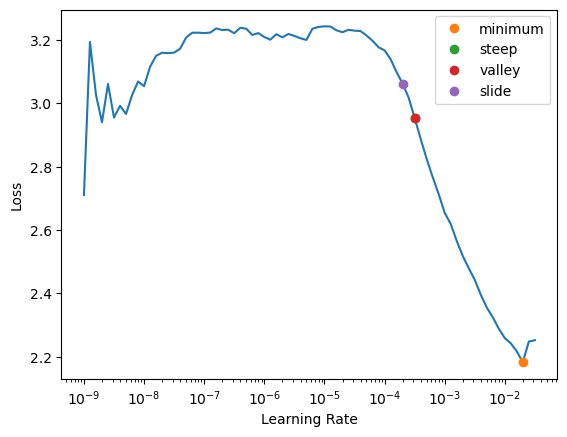

In [31]:
lr_minimum, lr_steep, lr_valley, lr_slide = learn.lr_find(start_lr=1e-9, suggest_funcs=[minimum, steep, valley, slide])

In [32]:
lr_minimum, lr_steep, lr_valley, lr_slide

(0.0019952623173594476,
 0.0003162277571391314,
 0.0003162277571391314,
 0.0001995262282434851)

In [31]:
set_seed(seed)

In [2]:
slice(*[1e-5, 2e-2])

slice(1e-05, 0.02, None)

In [32]:
learn.fit_one_cycle(10, lr_max=slice(1e-5, 2e-2), cbs=fit_cbs)

epoch,train_loss,valid_loss,mcrmse,time
0,0.590069,0.524998,0.560982,01:58
1,0.573292,0.730468,0.765047,02:00
2,0.544487,0.551028,0.586900,01:59
3,0.506508,0.541851,0.575684,01:53
4,0.495134,0.539350,0.575993,01:53
5,0.410843,0.512539,0.547041,01:53
6,0.404178,0.506759,0.540690,01:53
7,0.364305,0.493587,0.526696,01:53
8,0.340559,0.485799,0.518898,01:53
9,0.336492,0.485451,0.518319,01:52


In [33]:
# oof df
preds, targs = learn.get_preds()

In [34]:
preds.shape, targs.shape

(torch.Size([782, 6]), torch.Size([782, 6]))

In [35]:
preds = pd.DataFrame(preds)
preds.columns = ["pred_" + x for x in target_cols]
targs = pd.DataFrame(targs)
targs.columns = ["targ_" + x for x in target_cols]

In [36]:
oof_df = pd.concat([preds, targs], axis = 1)
oof_df

,pred_cohesion,pred_syntax,pred_vocabulary,pred_phraseology,pred_grammar,pred_conventions,targ_cohesion,targ_syntax,targ_vocabulary,targ_phraseology,targ_grammar,targ_conventions
0,3.733717,3.608072,3.765745,3.716778,3.703024,3.756756,3.5,4.0,3.5,3.5,4.0,4.0
1,3.252229,3.094465,3.317124,3.170558,3.113463,3.157710,3.0,3.0,3.5,3.5,3.0,3.0
2,2.826524,2.668943,2.924798,2.736864,2.649516,2.694057,3.5,2.5,3.5,3.0,3.0,3.0
3,3.614123,3.477585,3.652685,3.575231,3.547356,3.596668,3.5,3.0,3.5,3.5,3.5,4.0
4,3.645477,3.510763,3.679640,3.608292,3.575146,3.638493,4.0,3.5,3.0,4.0,3.5,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...
777,2.239976,2.101528,2.398314,2.191833,2.089370,2.130233,3.5,2.5,3.0,3.0,2.0,2.5
778,2.383245,2.241170,2.523932,2.319600,2.219038,2.258724,2.5,2.0,2.5,1.5,2.0,2.0
779,3.725348,3.593027,3.754735,3.699827,3.675921,3.734006,2.5,3.0,3.0,4.0,3.5,3.0
780,3.285907,3.135614,3.349255,3.213486,3.155712,3.205565,4.0,4.0,4.0,4.0,3.5,3.0
